# RescueTime: 
## Data Import, Data Visualization, Data Analysis, Year-in-Review

NOTE: Run [RescueTime Downloader](rescuetime_downloader.ipynb) to first extract your RescueTime data and prepare your info for Data Analysis

-----------

### Libraries and Dependencies

In [1]:
from datetime import date, datetime as dt, timedelta as td
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

### Import Data

In [2]:
activities = pd.read_csv("data/rescuetime-full-data-export.csv")
# if exists remove old index columns
activities.drop(['Unnamed: 0'], axis=1, inplace=True)
# relabel date to timestamp
activities.columns = ['Timestamp', 'Seconds', 'NumberPeople', 'Actitivity', 'Document', 'Category',
       'Productivity']

In [3]:
# activities.tail()

------

### Data Processing

In [4]:
# new column for productivitity level 
# as very productive, productive, neutral, distracted, very distracted
activities['Productive'] = activities['Productivity']

activities['Productive'] = activities['Productive'].map({-2: 'very distracting', 
                                                        -1: 'distracting',
                                                       0: 'neutral',
                                                       1: 'productive',
                                                       2: 'very productive'})
activities.Productive.unique()

array(['neutral', 'very productive', 'productive', 'very distracting',
       'distracting'], dtype=object)

In [5]:
# convert to datetime
activities['Timestamp'] = pd.to_datetime(activities['Timestamp'])

# reorder and reindex based on date
activities = activities.sort_values(by='Timestamp').reset_index(drop=True)

In [6]:
# date additions of Date timestamp
activities['Date'] = activities['Timestamp'].apply(lambda x: x.strftime('%Y-%m-%d')) 
activities['Year'] = activities['Timestamp'].dt.year
activities['Month'] = activities['Timestamp'].dt.month
activities['Mnth_yr'] = activities['Timestamp'].apply(lambda x: x.strftime('%Y-%m')) 
activities['Dow'] = activities['Timestamp'].dt.weekday
activities['Hour'] = activities['Timestamp'].dt.hour

-----

## Total Computer Time per Day

In [7]:
total_computer_time_by_date = activities.groupby(['Date'])['Seconds'].sum().reset_index(name='Seconds')

In [8]:
total_computer_time_by_date['Minutes'] = round(total_computer_time_by_date['Seconds'] / 60, 2)
total_computer_time_by_date['Hours'] = round(total_computer_time_by_date['Seconds'] / 60 / 60, 2)

In [9]:
# total_computer_time_by_date.tail()

In [10]:
# export
total_computer_time_by_date.to_csv("data/dates_computer_time.csv", index=False)

In [11]:
total_computer_time_by_date = total_computer_time_by_date.drop(['Seconds', 'Minutes'], axis=1)
total_computer_time_by_date = total_computer_time_by_date.set_index(['Date'])

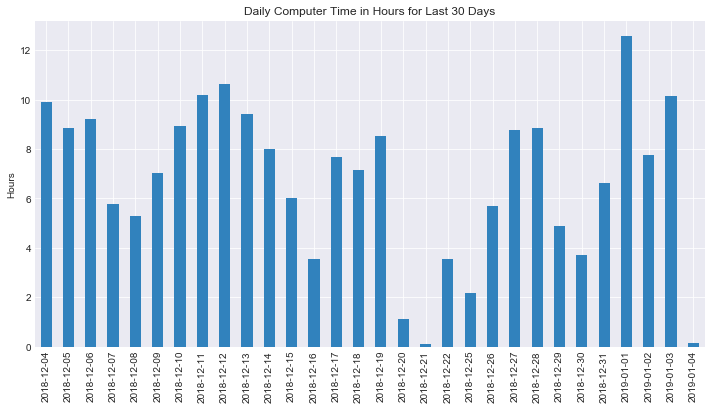

In [12]:
chart_title = 'Daily Computer Time in Hours for Last 30 Days'
plt.style.use('seaborn-darkgrid')
ax = total_computer_time_by_date.tail(30).plot.bar(stacked=True, rot=90, figsize=(12,6), colormap='tab20c', legend=False)
ax.set_xlabel('')
ax.set_ylabel('Hours')
ax.set_title(chart_title)
plt.show()

----

## Daily Productivity

In [13]:
total_by_date_productivity = activities.groupby(['Date', 'Productive'])['Seconds'].sum().reset_index(name='Seconds')
total_by_date_productivity['Minutes'] = round((total_by_date_productivity['Seconds'] / 60), 2)

In [14]:
# total_by_date_productivity
table = total_by_date_productivity.pivot_table(index='Date', columns='Productive', values='Seconds', aggfunc=np.sum)
table.to_csv("data/days_productive_time_full.csv")

In [15]:
# process and simplify productivity dimensions
days_productive_time = table.copy()
days_productive_time['productive_simple'] = days_productive_time['productive'] + days_productive_time['very productive']
days_productive_time.drop(['productive', 'very productive'], axis=1, inplace=True)
days_productive_time['distracting_simple'] = days_productive_time['distracting'] + days_productive_time['very distracting']
days_productive_time.drop(['distracting', 'very distracting'], axis=1, inplace=True)
days_productive_time.columns = ['Neutral', 'Productive', 'Distracting']

In [16]:
days_productive_time.to_csv("data/days_productive_time.csv")

In [17]:
# days_productive_time.tail(5)

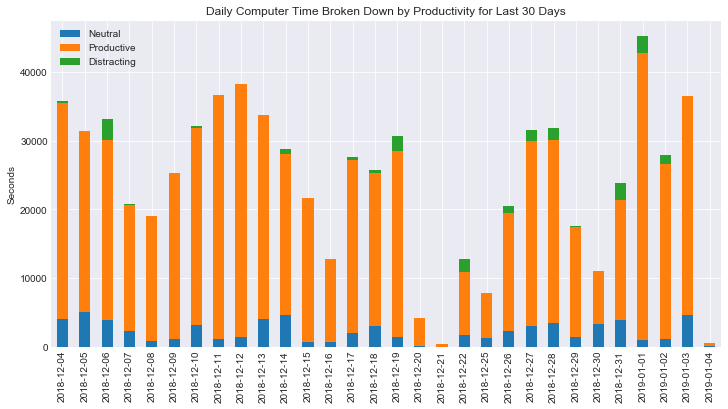

In [18]:
chart_title = 'Daily Computer Time Broken Down by Productivity for Last 30 Days'
plt.style.use('seaborn-darkgrid')
ax = days_productive_time.tail(30).plot.bar(stacked=True, rot=90, figsize=(12,6))
ax.set_xlabel('')
ax.set_ylabel('Seconds')
ax.set_title(chart_title)
plt.show()

---

# Productive Hours

In [19]:
hourly = activities.groupby(['Date', 'Hour', 'Productive'])['Seconds'].sum().reset_index(name='Seconds')
hourly['Minutes'] = round((hourly['Seconds'] / 60), 2)
# hourly.tail()

In [20]:
# export
hourly.to_csv("data/dates_hourly_productive_time.csv", index=False)

In [21]:
hourly_breakdown = hourly.pivot_table(index=['Date', 'Hour'], columns='Productive', values='Minutes', aggfunc=np.sum)

In [22]:
# hourly_breakdown.tail(10)

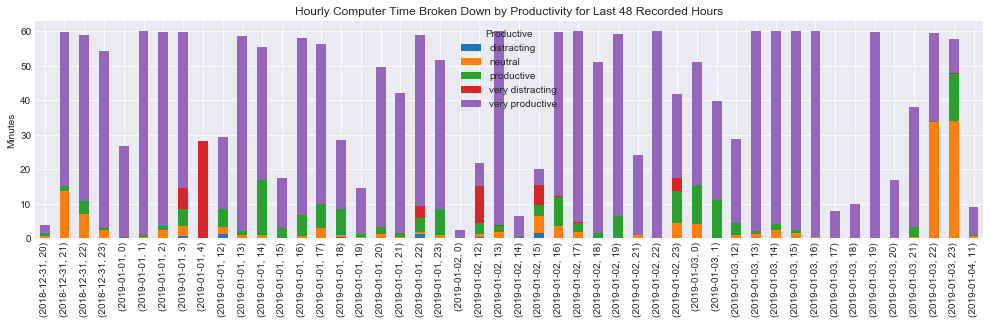

In [23]:
chart_title = 'Hourly Computer Time Broken Down by Productivity for Last 48 Recorded Hours'
plt.style.use('seaborn-darkgrid')
ax = hourly_breakdown.tail(48).plot.bar(stacked=True, rot=90, figsize=(17,4))
ax.set_xlabel('')
ax.set_ylabel('Minutes')
ax.set_title(chart_title)
plt.show()

---------------------

## Category Breakdown of Time Usage

In [24]:
# Categories
categories = activities.pivot_table(index=['Category'], values='Seconds', aggfunc=np.sum).sort_values(by='Seconds', ascending=False)
categories['Hours'] = round(categories['Seconds'] / 60 / 60, 1) 


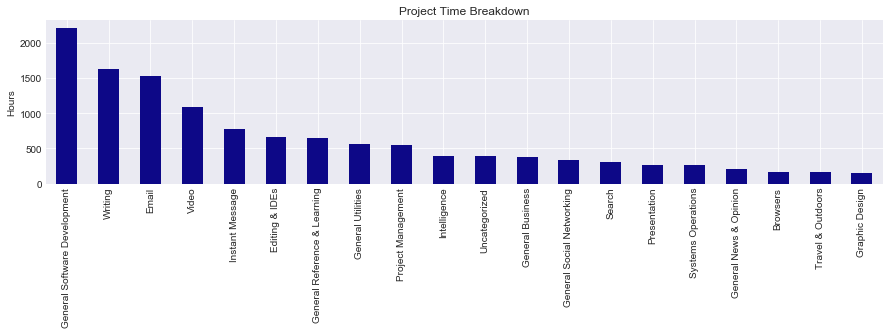

In [25]:
# Chart Project Time 
dataset = categories.head(20)
chart_title = 'Project Time Breakdown'

plt.style.use('seaborn-darkgrid')
ax = dataset.plot.bar(y='Hours', figsize=(15, 3), rot=90, colormap='plasma', legend=False)
ax.set_ylabel('Hours')
ax.set_xlabel('')

ax.set_title(chart_title)
plt.show()

In [26]:
# top 15 Categories
# categories.head(15)

-----

## Category Breakdown of Time Usage

In [27]:
# Categories
apps = activities.pivot_table(index=['Actitivity'], values='Seconds', aggfunc=np.sum).sort_values(by='Seconds', ascending=False)
apps['Hours'] = round(apps['Seconds'] / 60 / 60, 1) 


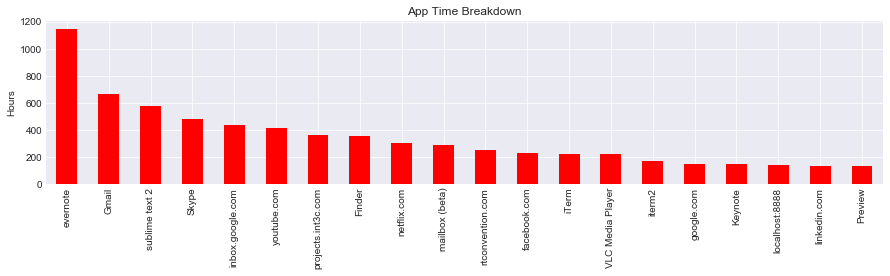

In [28]:
# Chart Project Time 
dataset = apps.head(20)
chart_title = 'App Time Breakdown'

plt.style.use('seaborn-darkgrid')
ax = dataset.plot.bar(y='Hours', figsize=(15, 3), rot=90, colormap='autumn', legend=False)
ax.set_ylabel('Hours')
ax.set_xlabel('')

ax.set_title(chart_title)
plt.show()

In [29]:
# top 15 Apps
# apps.head(15)

----

## Yearly Breakdown

In [30]:
year_data = activities.groupby(['Year', 'Productive'])['Seconds'].sum().reset_index(name='Seconds')
year_data['Hours'] = year_data['Seconds'] / 60 / 60
yearly_data = np.round(year_data.pivot_table(index=['Year'], columns='Productive', values='Hours', aggfunc=np.sum),2)
# change order
yearly_data = yearly_data[['very productive', 'productive', 'neutral', 'distracting', 'very distracting']]

In [31]:
# yearly_data

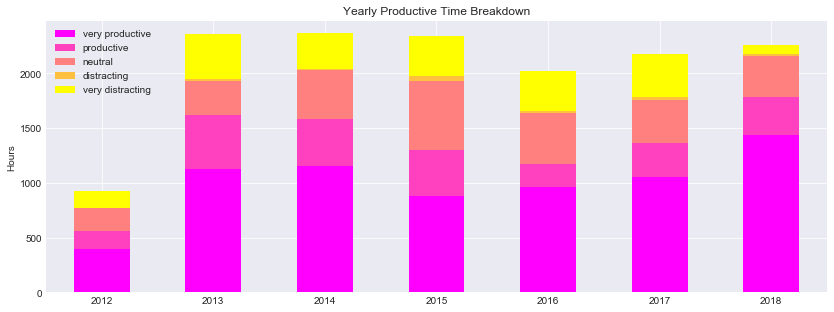

In [32]:
# Chart Yearly Time 
dataset = yearly_data[:-1]
chart_title = 'Yearly Productive Time Breakdown'

plt.style.use('seaborn-darkgrid')
ax = dataset.plot.bar(figsize=(14, 5), rot=0, colormap='spring', stacked=True)
ax.set_ylabel('Hours')
ax.set_xlabel('')
ax.legend(loc='upper left')
ax.set_title(chart_title)
plt.show()

-----

## Monthly Breakdown

In [33]:
activities.columns

Index(['Timestamp', 'Seconds', 'NumberPeople', 'Actitivity', 'Document',
       'Category', 'Productivity', 'Productive', 'Date', 'Year', 'Month',
       'Mnth_yr', 'Dow', 'Hour'],
      dtype='object')

In [34]:
month_data = activities.groupby(['Mnth_yr', 'Productive'])['Seconds'].sum().reset_index(name='Seconds')
month_data['Hours'] = month_data['Seconds'] / 60 / 60
monthly_data = np.round(month_data.pivot_table(index=['Mnth_yr'], columns='Productive', values='Hours', aggfunc=np.sum),2)
# change order
monthly_data = monthly_data[['very productive', 'productive', 'neutral', 'distracting', 'very distracting']]

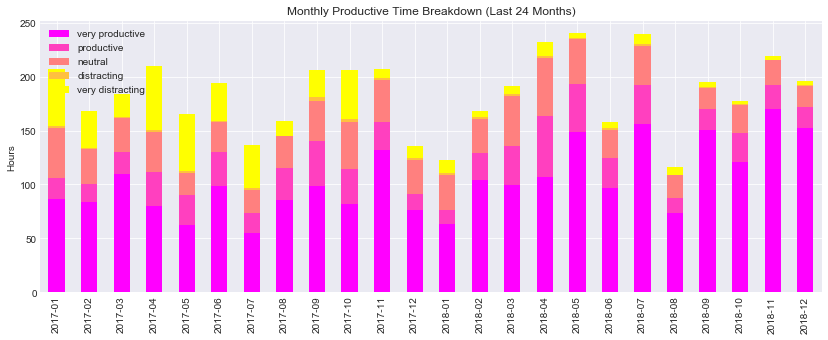

In [35]:
# Chart Monthly Time 
dataset = monthly_data[:-1].tail(24)
chart_title = 'Monthly Productive Time Breakdown (Last 24 Months)'

plt.style.use('seaborn-darkgrid')
ax = dataset.plot.bar(figsize=(14, 5), rot=90, colormap='spring', stacked=True)
ax.set_ylabel('Hours')
ax.set_xlabel('')
ax.legend(loc='best')
ax.set_title(chart_title)
plt.show()

----

# Rescuetime Usage Data Summary

In [36]:
# Life-time Project Time Summary
print('====== RescueTme Time Lifetime Summary ====== ')
print('Total Number of Tracked Days: {:,}'.format(len(total_computer_time_by_date)))
total_hours = round(total_computer_time_by_date['Hours'].sum().item(),2)
print('All-time Computer Time in Days: {:,}'.format(round(total_hours/24),1))
print('All-time Computer in Hours: {:,}'.format(total_hours))
daily_average = round(total_computer_time_by_date['Hours'].mean(),1)
print('Daily Average (of tracked days): {:,} hrs'.format(daily_average))
print(' ')

print('Top 5 Days with Most Hours:')
for index, row in total_computer_time_by_date.sort_values(by=['Hours'], ascending=False).head(5).iterrows():
    print("* " + str(row["Hours"]) + " hrs" + " on " + str(row.name))
print(' ')

print('Top 7 Apps by Usage:')
for index, row in apps.head(7).iterrows():
    print("* " + str(row["Hours"]) + " hrs" + ": " + str(row.name))
print(' ')

====== RescueTme Time Lifetime Summary ====== 
Total Number of Tracked Days: 2,298
All-time Computer Time in Days: 603
All-time Computer in Hours: 14,481.72
Daily Average (of tracked days): 6.3 hrs
 
Top 5 Days with Most Hours:
* 15.22 hrs on 2012-12-20
* 14.73 hrs on 2012-12-31
* 14.31 hrs on 2014-01-31
* 14.25 hrs on 2014-01-06
* 14.14 hrs on 2013-04-19
 
Top 7 Apps by Usage:
* 1148.1 hrs: evernote
* 664.3 hrs: Gmail
* 576.7 hrs: sublime text 2
* 478.1 hrs: Skype
* 436.7 hrs: inbox.google.com
* 412.4 hrs: youtube.com
* 367.0 hrs: projects.int3c.com
 


----

# Year in Review Data Analysis

In [37]:
# Set Year
target_year = 2018

In [38]:
# use existing data
days_productive_time = pd.read_csv("data/days_productive_time.csv")
days_productive_time.fillna(0, inplace=True)
days_productive_time['Date'] = pd.to_datetime(days_productive_time['Date'])
days_productive_time['Year'] = days_productive_time['Date'].dt.year
days_productive_time['Month'] = days_productive_time['Date'].dt.month

### General Summary

In [39]:
def yearly_summary(year):  
    print('====== {} RescueTime Summary ======'.format(year))
    # Data Setup
    year_data = activities[(activities['Year'] == year)]
    
    year_time_dates = year_data.groupby(['Date'])['Seconds'].sum().to_frame()
    year_time_dates['Hours'] = round(year_time_dates['Seconds']/60/60,1)
    print('{:,} total computer time dates'.format(len(year_time_dates)))
    print('{:,} total computer hours'.format(round(year_time_dates['Hours'].sum(),2)))
    daily_average = round(year_time_dates['Hours'].mean(),1)
    print('Daily Average (of tracked days): {:,} hrs'.format(daily_average))
    print('')

    print('Top 5 Days with Most Hours:')
    for index, row in year_time_dates.sort_values(by=['Hours'], ascending=False).head(5).iterrows():
        print("* " + str(row["Hours"]) + " hrs on " + row.name)
    print(' ')
    
    print('Top 7 Categories:')
    year_categories = year_data.groupby(['Category'])['Seconds'].sum().to_frame()
    year_categories['Hours'] = round(year_categories['Seconds']/60/60,1)
    for index, row in year_categories.sort_values(by=['Hours'], ascending=False).head(7).iterrows():
        print("* " + str(row["Hours"]) + " hrs on " + row.name)
    print(' ')
    
    print('Top 7 Apps:')
    year_categories = year_data.groupby(['Category'])['Seconds'].sum().to_frame()
    year_categories['Hours'] = round(year_categories['Seconds']/60/60,1)
    for index, row in year_categories.sort_values(by=['Hours'], ascending=False).head(7).iterrows():
        print("* " + str(row["Hours"]) + " hrs on " + row.name)
    print(' ')

In [40]:
yearly_summary(year=target_year)

====== 2018 RescueTime Summary ======
344 total computer time dates
2,256.7 total computer hours
Daily Average (of tracked days): 6.6 hrs

Top 5 Days with Most Hours:
* 14.1 hrs on 2018-10-29
* 13.0 hrs on 2018-07-09
* 12.4 hrs on 2018-11-21
* 11.5 hrs on 2018-04-13
* 11.5 hrs on 2018-11-20
 
Top 7 Categories:
* 563.7 hrs on General Software Development
* 429.8 hrs on Writing
* 170.7 hrs on General Reference & Learning
* 96.9 hrs on General Utilities
* 91.2 hrs on Editing & IDEs
* 90.3 hrs on Search
* 87.2 hrs on General Business
 
Top 7 Apps:
* 563.7 hrs on General Software Development
* 429.8 hrs on Writing
* 170.7 hrs on General Reference & Learning
* 96.9 hrs on General Utilities
* 91.2 hrs on Editing & IDEs
* 90.3 hrs on Search
* 87.2 hrs on General Business
 


### Day of Week Comparison

In [41]:
def yearly_workspace_dow_chart(year):    
    # Data Setup
    year_data = activities[(activities['Year'] == year)]
    
    year_dow = year_data.groupby(['Date', 'Dow', 'Productive'])['Seconds'].sum().reset_index(name='Seconds')
    year_dow['Hours'] = year_dow['Seconds'] / 60 / 60
    yearly_dow = np.round(year_dow.pivot_table(index=['Dow'], columns='Productive', values='Hours', aggfunc=np.mean),2)
    # change order
    yearly_dow = yearly_dow[['very productive', 'productive', 'neutral', 'distracting', 'very distracting']]

    chart_title = '{} Daily Computer Time by Day of Week'.format(year, yearly_dow.sum())
    plt.style.use('seaborn-darkgrid')
    ax = yearly_dow.plot.bar(stacked=True, rot=0, figsize=(12,6), colormap='spring')
    ax.set_xlabel('')
    ax.set_ylabel('Hours')
    ax.set_title(chart_title)
    plt.show()

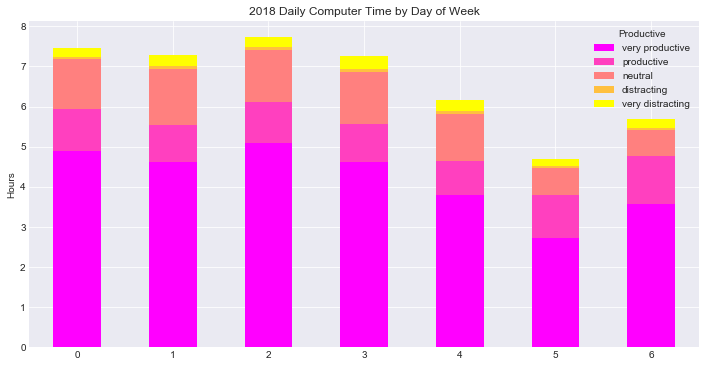

In [42]:
yearly_workspace_dow_chart(year=target_year)

### RescueTime as a Yearly Heatmap Calendar

In [43]:
# Helper Function to Create Heat Map from Data
# Adapted from https://stackoverflow.com/questions/32485907/matplotlib-and-numpy-create-a-calendar-heatmap
DAYS = ['Sun.', 'Mon.', 'Tues.', 'Wed.', 'Thurs.', 'Fri.', 'Sat.']
MONTHS = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.']


def date_heatmap(series, start=None, end=None, mean=False, ax=None, **kwargs):
    '''Plot a calendar heatmap given a datetime series.

    Arguments:
        series (pd.Series):
            A series of numeric values with a datetime index. Values occurring
            on the same day are combined by sum.
        start (Any):
            The first day to be considered in the plot. The value can be
            anything accepted by :func:`pandas.to_datetime`. The default is the
            earliest date in the data.
        end (Any):
            The last day to be considered in the plot. The value can be
            anything accepted by :func:`pandas.to_datetime`. The default is the
            latest date in the data.
        mean (bool):
            Combine values occurring on the same day by mean instead of sum.
        ax (matplotlib.Axes or None):
            The axes on which to draw the heatmap. The default is the current
            axes in the :module:`~matplotlib.pyplot` API.
        **kwargs:
            Forwarded to :meth:`~matplotlib.Axes.pcolormesh` for drawing the
            heatmap.

    Returns:
        matplotlib.collections.Axes:
            The axes on which the heatmap was drawn. This is set as the current
            axes in the `~matplotlib.pyplot` API.
    '''
    # Combine values occurring on the same day.
    dates = series.index.floor('D')
    group = series.groupby(dates)
    series = group.mean() if mean else group.sum()

    # Parse start/end, defaulting to the min/max of the index.
    start = pd.to_datetime(start or series.index.min())
    end = pd.to_datetime(end or series.index.max())

    # We use [start, end) as a half-open interval below.
    end += np.timedelta64(1, 'D')

    # Get the previous/following Sunday to start/end.
    # Pandas and numpy day-of-week conventions are Monday=0 and Sunday=6.
    start_sun = start - np.timedelta64((start.dayofweek + 1) % 7, 'D')
    end_sun = end + np.timedelta64(7 - end.dayofweek - 1, 'D')

    # Create the heatmap and track ticks.
    num_weeks = (end_sun - start_sun).days // 7
    heatmap = np.zeros((7, num_weeks))
    ticks = {}  # week number -> month name
    for week in range(num_weeks):
        for day in range(7):
            date = start_sun + np.timedelta64(7 * week + day, 'D')
            if date.day == 1:
                ticks[week] = MONTHS[date.month - 1]
            if date.dayofyear == 1:
                ticks[week] += f'\n{date.year}'
            if start <= date < end:
                heatmap[day, week] = series.get(date, 0)

    # Get the coordinates, offset by 0.5 to align the ticks.
    y = np.arange(8) - 0.5
    x = np.arange(num_weeks + 1) - 0.5

    # Plot the heatmap. Prefer pcolormesh over imshow so that the figure can be
    # vectorized when saved to a compatible format. We must invert the axis for
    # pcolormesh, but not for imshow, so that it reads top-bottom, left-right.
    ax = ax or plt.gca()
    mesh = ax.pcolormesh(x, y, heatmap, **kwargs)
    ax.invert_yaxis()

    # Set the ticks.
    ax.set_xticks(list(ticks.keys()))
    ax.set_xticklabels(list(ticks.values()))
    ax.set_yticks(np.arange(7))
    ax.set_yticklabels(DAYS)

    # Set the current image and axes in the pyplot API.
    plt.sca(ax)
    plt.sci(mesh)

    return ax

In [44]:
def year_heat_chart(year, productivity_type='All'):   

    # Filter by Year
    year_data = days_productive_time[(days_productive_time['Year'] == year)].copy()
    
    if productivity_type == 'Productive':
        year_dates_data = year_data.groupby(['Date'])['Productive'].sum().reset_index(name='Seconds')
    elif productivity_type == 'Distracting':
        year_dates_data = year_data.groupby(['Date'])['Distracting'].sum().reset_index(name='Seconds')
    else: # all
        year_data['Seconds'] = year_data['Neutral'] + year_data['Productive'] + year_data['Distracting']
        year_dates_data = year_data.groupby(['Date'])['Seconds'].sum().reset_index(name='Seconds')
        
    year_dates_data['Hours'] = year_dates_data['Seconds'] / 60 / 60
    year_dates_data['Minutes'] = year_dates_data['Seconds'] / 60
    
    # Generate all dates in that year
    first_date = str(year)+'-01-01'#runs_2018_dist['date'].head(1).values[0]
    last_date = str(year)+'-12-31'#runs_2018_dist['date'].tail(1).values[0]
    all_dates = pd.date_range(start=first_date, end=last_date)
    all_dates = pd.DataFrame(all_dates, columns=['Date'])
    
    # combine actual runs by date with total dates possible
    year_data = pd.merge(left=all_dates, right=year_dates_data, 
                                 left_on="Date", right_on="Date", how="outer")
    year_data['Minutes'].fillna(0, inplace=True)
    year_data = year_data.set_index(pd.DatetimeIndex(year_data['Date']))
    
    max_daily_hours = round(year_data['Hours'].max(),0)
    
    # key stat and title
    total_hours = round(year_data['Hours'].sum(),1)
    chart_title = '{} RescueTime {} Time | Total Time {:,} Hrs'.format(year, productivity_type, total_hours)
    
    # set chart data
    data = pd.Series(year_data.Hours)
    data.index = year_data.index 
    
    # plot data
    figsize = plt.figaspect(7 / 56)
    fig = plt.figure(figsize=figsize)
    ax = date_heatmap(data, edgecolor='black')
    max_hrs = int(round(data.max(),0))
    steps = int(round(max_hrs / 6, 0))
    plt.colorbar(ticks=range(0, max_hrs, steps), pad=0.02)
    cmap = mpl.cm.get_cmap('Greens', max_daily_hours)
    plt.set_cmap(cmap)
    plt.clim(0, max_daily_hours)
    ax.set_aspect('equal')
    ax.set_title(chart_title)
    plt.show()

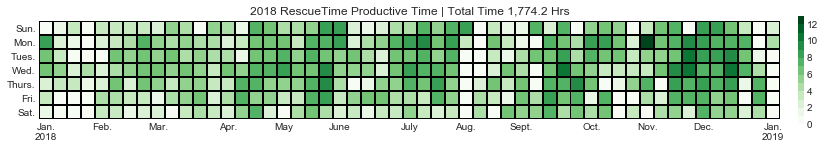

In [45]:
year_heat_chart(year=target_year, productivity_type='Productive')

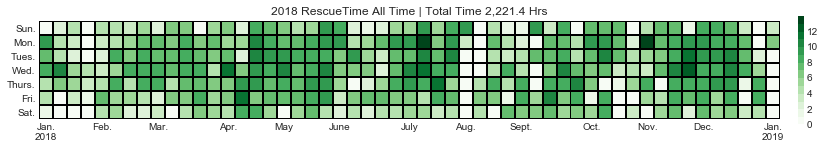

In [46]:
year_heat_chart(year=target_year, productivity_type='All')

## Monthly Breakdown

In [47]:
def yearly_month_chart(year):    
    # Data Setup
    year_data = activities[(activities['Year'] == year)]
    
    year_month = year_data.groupby(['Month', 'Productive'])['Seconds'].sum().reset_index(name='Seconds')
    year_month['Hours'] = year_month['Seconds'] / 60 / 60
    year_monthly = np.round(year_month.pivot_table(index=['Month'], columns='Productive', values='Hours', aggfunc=np.mean),2)
    # change order
    year_monthly = year_monthly[['very productive', 'productive', 'neutral', 'distracting', 'very distracting']]

    chart_title = '{} Monthly RescueTime Hours'.format(year)

    plt.style.use('seaborn-darkgrid')
    ax = year_monthly.plot.bar(stacked=True, rot=0, figsize=(12,6), colormap='spring')
    ax.set_xlabel('')
    ax.set_ylabel('Hours')
    ax.set_title(chart_title)
    plt.show()

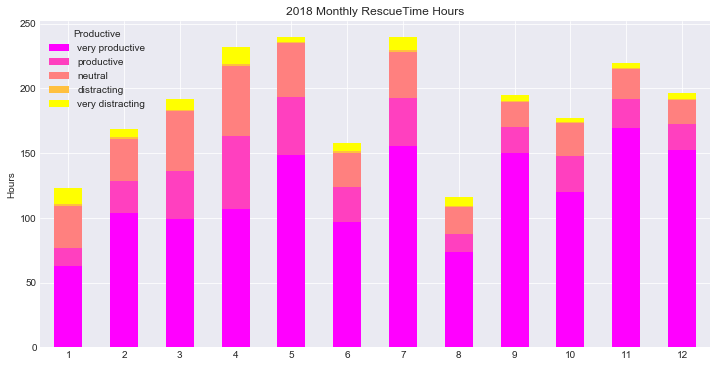

In [48]:
yearly_month_chart(year=target_year)

## Yearly Hourly Breakdown

In [49]:
# let's use some existing data 
hourly = pd.read_csv("data/dates_hourly_productive_time.csv")
hourly['Date'] = pd.to_datetime(hourly['Date'])
hourly['Year'] = hourly['Date'].dt.year

In [50]:
def yearly_hourly_chart(year):    
    year_hours_data = hourly[(hourly['Year'] == year)]

    year_hours = year_hours_data.groupby(['Hour', 'Productive'])['Seconds'].sum().reset_index(name='Seconds')
    year_hours['Hours'] = year_hours['Seconds'] / 60 / 60
    yearly_hours = np.round(year_hours.pivot_table(index=['Hour'], columns='Productive', values='Hours', aggfunc=np.mean),2)
    # change order
    yearly_hours = yearly_hours[['very productive', 'productive', 'neutral', 'distracting', 'very distracting']]

    chart_title = '{} RescueTime Hourly Breakdown'.format(year)

    plt.style.use('seaborn-darkgrid')
    ax = yearly_hours.plot.bar(stacked=True, rot=0, figsize=(12,6), colormap='spring')
    ax.set_xlabel('')
    ax.set_ylabel('Hours')
    ax.set_title(chart_title)
    plt.show()

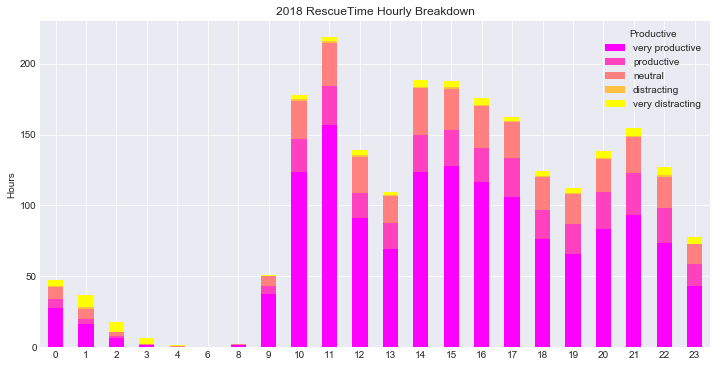

In [51]:
yearly_hourly_chart(year=target_year)